In [311]:
import torch
from torchvision import transforms,datasets
from torch.autograd import Variable
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [312]:
dataset_csv = pd.read_csv('healthcare-dataset-stroke-data.csv')
del dataset_csv['id']
print(dataset_csv.info())
dataset_csv['bmi'].mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
None


28.893236911794666

In [313]:
dataset_csv['gender'] = dataset_csv['gender'].replace(['Male','Female','Other'],[0,1,2]) 

dataset_csv['work_type'] = dataset_csv['work_type'].replace(['Private','Self-employed','children','Govt_job','Never_worked'],[0,1,2,3,4])

dataset_csv['Residence_type'] = dataset_csv['work_type'].replace(['Rural','Urban'],[0,1])

dataset_csv['smoking_status'] = dataset_csv['smoking_status'].replace(['never smoked','Unknown','formerly smoked','smokes'],[0,1,2,3])

dataset_csv['ever_married'] = dataset_csv['ever_married'].replace(['Yes','No'],[1,0])

dataset_csv['Residence_type'] = dataset_csv['Residence_type'].replace(['Urban','Rural'],[0,1])

dataset_csv['bmi'] = dataset_csv['bmi'].fillna(dataset_csv['bmi'].mean())
dataset_csv = dataset_csv.astype('float')

In [314]:
print(dataset_csv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   float64
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   float64
 3   heart_disease      5110 non-null   float64
 4   ever_married       5110 non-null   float64
 5   work_type          5110 non-null   float64
 6   Residence_type     5110 non-null   float64
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   float64
 10  stroke             5110 non-null   float64
dtypes: float64(11)
memory usage: 439.3 KB
None


In [315]:

dataX = dataset_csv.values[:,:-1]
norm = preprocessing.MinMaxScaler().fit(dataX)
dataX = norm.transform(dataX)

dataY = dataset_csv.values[:,-1]
dataY = dataY.reshape(-1,1)

In [316]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float64)
    self.y = torch.tensor(y,dtype=torch.float64)
    self.length = self.x.shape[0]

  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(dataX,dataY)
#DataLoader
trainloader = DataLoader(trainset,batch_size=10,shuffle=False)

In [317]:
import torch.nn as nn
import torch.nn.functional as F

In [327]:
#Neural net
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(10,10)
    self.fc2 = nn.Linear(10,1)

  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    return x

In [341]:
model = Net()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

#Training
epochs = 10
batches = int(len(dataX)/5)
print(batches)
losses = []

cont = []
c = 0
for ep in range(epochs):
  for i in range(batches):
    x_train = dataX[i*5:(i+1)*5,]
    y_train = dataY[i*5:(i+1)*5,]

    x_train = torch.tensor(x_train,dtype=torch.float32)
    y_train = torch.tensor(y_train,dtype=torch.float32)
    
    optimizer.zero_grad()
    y_hat = model(x_train)

    loss = criterion(y_hat,y_train)
    loss.backward()
    optimizer.step()

    c += 1
    cont.append([c])
    losses.append(loss.data.numpy())
  print(loss,c)

1022
tensor(2.1446e-05, grad_fn=<BinaryCrossEntropyBackward>) 1022
tensor(0.0049, grad_fn=<BinaryCrossEntropyBackward>) 2044
tensor(3.7789e-06, grad_fn=<BinaryCrossEntropyBackward>) 3066
tensor(0.0009, grad_fn=<BinaryCrossEntropyBackward>) 4088
tensor(0.0118, grad_fn=<BinaryCrossEntropyBackward>) 5110
tensor(0.0106, grad_fn=<BinaryCrossEntropyBackward>) 6132
tensor(0.0004, grad_fn=<BinaryCrossEntropyBackward>) 7154
tensor(0.0004, grad_fn=<BinaryCrossEntropyBackward>) 8176
tensor(0.0139, grad_fn=<BinaryCrossEntropyBackward>) 9198
tensor(0.0118, grad_fn=<BinaryCrossEntropyBackward>) 10220


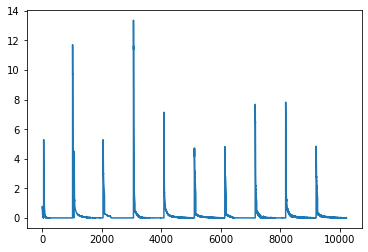

In [342]:
plt.plot(cont,losses)

In [343]:
print(model(torch.tensor(norm.transform(np.array([[0,53,0,0,1,0,0,79,30,0]])),dtype=torch.float32)))
print(model(torch.tensor(dataX[0],dtype=torch.float32)),dataY[0])

tensor([[0.0106]], grad_fn=<SigmoidBackward>)
tensor([0.0438], grad_fn=<SigmoidBackward>) [1.]
